# Load libraries and utils

In [22]:
%load_ext autoreload
%autoreload 2
from hyperopt.fnn import HyperOptFnn
from hyperopt.sklearn_gridsearch import HyperOptScikitFda
from images import images_path
from shapley.shapley_fda import ShapleyFda
from skfda.ml.regression import KNeighborsRegressor, LinearRegression
from skfda.representation.basis import BSplineBasis
from utils.simulator import FdaSimulator
from utils.utils_workflow import predict_no_verbose, predict_np_reshape
import keras_tuner
import matplotlib.pyplot as plt
import numpy as np
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
fda_simulator = FdaSimulator()
domain_range = fda_simulator.domain_range
abscissa_points = fda_simulator.abscissa_points

# Create data

In [6]:
# Prepare some global parameters used to generate data
cnt = 30
alpha_p =  1 * cnt
beta_p = 3 * cnt
positions = [0.15, 0.35, 0.55, 0.85]
n_basis_simulated_data = 31

X, phi_X, epsilon, beta_data, col_indexes_bct, target = fda_simulator.simulate(
    #type_covariate="fourier_expansion",
    #type_transformation="linear_unimodal",
    type_covariate="fourier_expansion",
    type_transformation="linear_unimodal",
    sample_size=200,
    eta=0.25,
    datasets_type = ["train", "validation", "test"],
    # Series representation
    n_basis_simulated_data=n_basis_simulated_data,
    sd_x=0.01,
    # Beta parameters
    alpha_param=alpha_p,
    beta_param=beta_p,
    # Brownian parameters
    intercept_brownian=0,
    slope_brownian=1,
    positions=positions
)

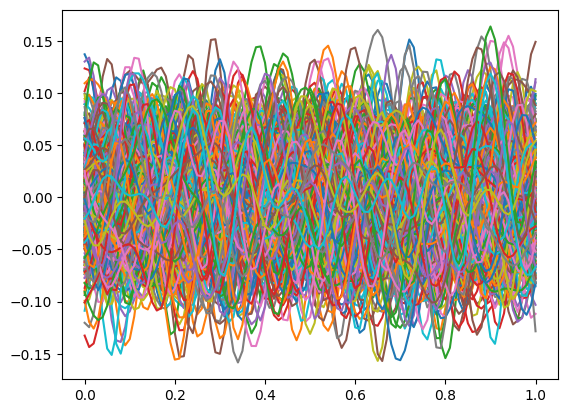

In [7]:
X_train, X_validation, X_test = X
X_full = np.row_stack((X_train, X_validation))

target_train, target_validation, target_test = target
target_full = np.row_stack((target_train, target_validation))

beta_train, beta_validation, beta_test = beta_data
epsilon_train, epsilon_validation, epsilon_test = epsilon

X_train_grid = fda_simulator.to_fdata_grid(X_train)
X_validation_grid = fda_simulator.to_fdata_grid(X_validation)
X_test_grid = fda_simulator.to_fdata_grid(X_test)
X_full_grid = fda_simulator.to_fdata_grid(X_full)
zzz = X_full_grid.plot()
if False:
    plt.savefig(os.path.join(images_path, "scenario_1_covariate.eps"), format="eps")
    plt.savefig(os.path.join(images_path, "scenario_1_covariate.pdf"), format="pdf")

In [8]:
phi_train, phi_validation, phi_test = phi_X

In [9]:
np.var(epsilon_train)/(np.var(phi_train) + np.var(epsilon_train))

0.23635237924816577

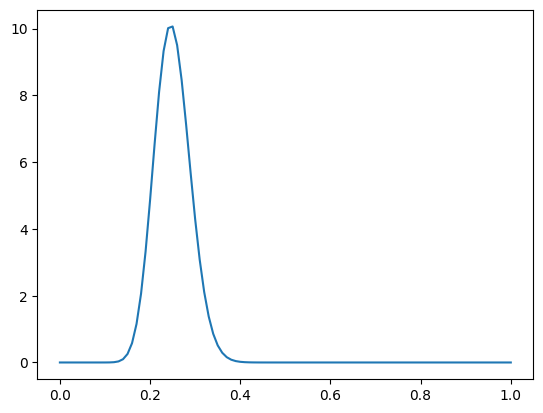

In [10]:
if not beta_train is None:
    beta_data_grid = fda_simulator.to_fdata_grid(beta_train)
    plt.plot(
        abscissa_points,
        np.reshape(beta_train, newshape=(1, -1))[0], '-'
    )

# Linear model

In [11]:
hyperopt_lm = HyperOptScikitFda(
    LinearRegression,
    abscissa_points=abscissa_points,
    domain_range=domain_range,
)
n_basis_list = list(range(4, 30, 1))
hist_lm = hyperopt_lm.search(
    X_train=X_train,
    y_train=target_train[:, 0],
    X_val=X_validation,
    y_val=target_validation[:, 0],
    basis=BSplineBasis,
    n_basis_list=n_basis_list,
)
best_score_lm_list = [x.best_score_ for x in hist_lm]
position_best_score_lm = np.argmax(best_score_lm_list)
best_n_basis_lm = n_basis_list[position_best_score_lm]
best_params_lm = hist_lm[position_best_score_lm].best_params_
best_model_lm = hyperopt_lm.cls_estimator(**best_params_lm)

In [12]:
best_basis_lm = BSplineBasis(
    n_basis=best_n_basis_lm,
    domain_range=domain_range,
)
X_full_bspline = X_full_grid.to_basis(best_basis_lm)
X_test_bspline = X_test_grid.to_basis(best_basis_lm)

In [13]:
_ = best_model_lm.fit(X_full_bspline, target_full[:, 0])

In [14]:
# Transform predict function to use a numpy array as input
predict_best_model_lm = predict_np_reshape(
    grid_points=abscissa_points,
    domain_range=domain_range,
    basis=X_full_bspline.basis,
    predict_fn=best_model_lm.predict,
)

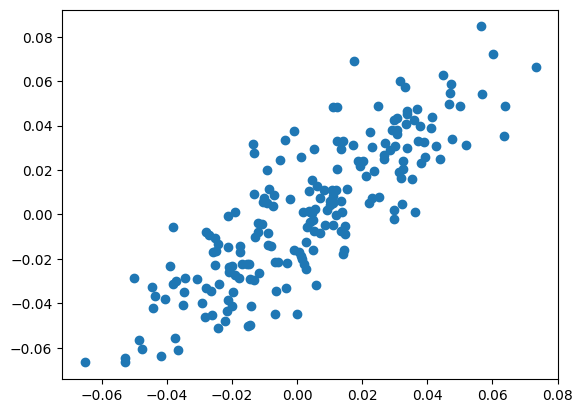

In [15]:
predictions_lm = predict_best_model_lm(X_test)
plt.scatter(predictions_lm, target_test)

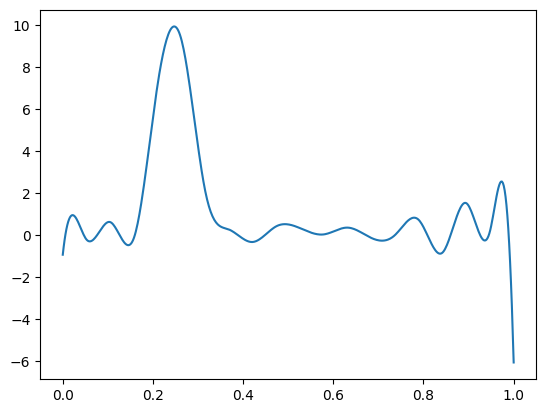

In [16]:
zzz = best_model_lm.coef_[0].plot()

# Knn model

In [15]:
hyperopt_knn = HyperOptScikitFda(
    KNeighborsRegressor,
    abscissa_points=abscissa_points,
    domain_range=domain_range,
)
hist_knn = hyperopt_knn.search(
    params={"n_neighbors": range(3, 30, 1)},
    X_train=X_train,
    y_train=target_train,
    X_val=X_validation,
    y_val=target_validation
)
best_score_knn_list = [x.best_score_ for x in hist_knn]
position_best_score_knn = np.argmax(best_score_knn_list)
best_params_knn = hist_knn[position_best_score_knn].best_params_
best_model_knn = hyperopt_knn.cls_estimator(**best_params_knn)
_ = best_model_knn.fit(X_full, target_full)

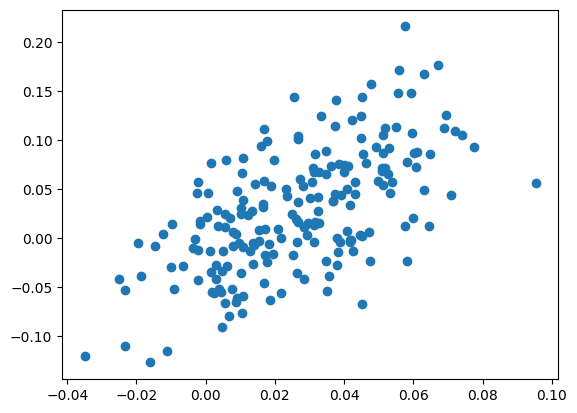

In [16]:
predictions_knn = best_model_knn.predict(X_test)
plt.scatter(predictions_knn, target_test)

# Neural network

In [17]:
hyperopt_fnn = HyperOptFnn(
    input_shape=(X_train.shape[1], 1),
    resolution=X_train.shape[1]
)

tuner_fnn = keras_tuner.RandomSearch(
    hyperopt_fnn,
    objective="val_loss",
    max_trials=15,
    overwrite=True,
    directory=".",
    project_name="tune_hypermodel",
)

tuner_fnn.search(
    X_train,
    target_train,
    validation_data=(X_validation, target_validation),
    verbose=False,
)

In [18]:
# Data of the best fnn model
best_params_fnn = tuner_fnn.get_best_hyperparameters()[0]
best_epochs_fnn = best_params_fnn.get("epochs")
best_batch_size_fnn = best_params_fnn.get("batch_size")
print("best_epochs_fnn:", best_epochs_fnn)
print("best_batch_size_fnn:", best_batch_size_fnn)
tuner_fnn.get_best_models(1)[0].summary()

best_epochs_fnn: 52
best_batch_size_fnn: 8


/Users/cristianpachon/Documents/technical/shapley_fda_experiments/.shapley_fda_experiments/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 101, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_0 (FunctionalDense)       │ (None, 101, 15)        │            90 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (FunctionalDense)       │ (None, 101, 6)         │           540 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (FunctionalDense)       │ (None, 101, 11)        │           396 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (FunctionalDense)       │ (None, 101, 8)         │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (FunctionalDense)        │ (None, 1)              │           120 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,674 (6.54 KB)

 Trainable params: 1,674 (6.54 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
hyperopt_best_fnn = HyperOptFnn(
    input_shape=(X_train.shape[1], 1),
    resolution=X_train.shape[1]
)
best_model_fnn = hyperopt_best_fnn.build(best_params_fnn)
history_best_fnn = hyperopt_best_fnn.fit(
    hp=best_params_fnn,
    model=best_model_fnn,
    X=X_full,
    y=target_full,
    epochs=best_epochs_fnn,
    batch_size=best_batch_size_fnn,
    verbose=False
)

In [20]:
best_model_fnn.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 101, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_0 (FunctionalDense)       │ (None, 101, 15)        │            90 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (FunctionalDense)       │ (None, 101, 6)         │           540 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (FunctionalDense)       │ (None, 101, 11)        │           396 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (FunctionalDense)       │ (None, 101, 8)         │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (FunctionalDense)        │ (None, 1)              │           120 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,024 (19.63 KB)

 Trainable params: 1,674 (6.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,350 (13.09 KB)

In [21]:
predict_best_model_fnn = predict_no_verbose(best_model_fnn.predict)

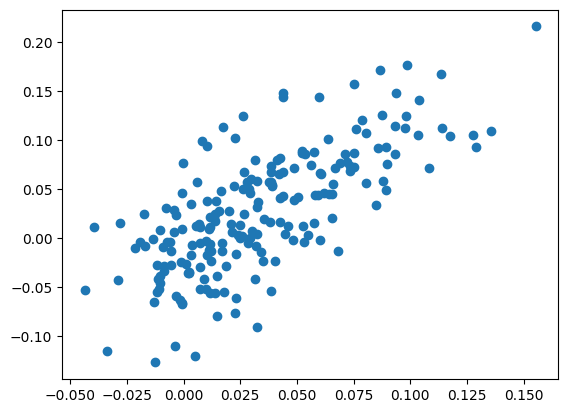

In [22]:
predictions_fnn = predict_best_model_fnn(X_test)
plt.scatter(predictions_fnn, target_test)

# Shapley values

In [39]:
num_permutations = [1000, 2000, 5000]
num_intervals = 20
compute_mrmr_distance_correlation = False
compute_mrmr_r2 = False
verbose = False
predict_fns = predict_best_model_lm

In [40]:
for n_perm in num_permutations:
    shapley_fda = ShapleyFda(
        X=X_test,
        abscissa_points=abscissa_points,
        target=target_test,
        domain_range=fda_simulator.domain_range,
        verbose=False,
    )

    shapley_values = shapley_fda.compute_shapley_value(
        num_permutations=n_perm,
        predict_fns=predict_fns,
        num_intervals=num_intervals,
        compute_mrmr_r2=compute_mrmr_r2,
        compute_mrmr_distance_correlation=compute_mrmr_distance_correlation,
    )
    print("number of permutations:", n_perm, "time:", shapley_values["execution_time"])

number of permutations: 1000 time: 86.45900893211365
number of permutations: 2000 time: 187.62344098091125
number of permutations: 5000 time: 396.7908480167389
